In [41]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from lifelines.statistics import logrank_test
import seaborn as sns
from scipy import stats

# OS Analysis

In [2]:
mutated_genes =  pd.read_csv('Mutated_Genes.txt', sep='\t', header=0)
metadata = pd.read_csv('TCGA.HNSC.metadata.txt', sep='\t', header=0,index_col = [0])

In [3]:
mutated_genes = mutated_genes.sort_values(by=['# Mut'],ascending=False)[:100].reset_index(drop = True)

In [4]:
gene_list = np.array(mutated_genes['Gene'])

In [69]:
# add 'CEACAM5', 'CEACAM6', 'CLCA4' in array bc their prevalence in cancer gene
gene_list = np.append(gene_list, np.array(['CEACAM5', 'CEACAM6', 'CLCA4']))

In [70]:
# Load the gene expression data
gene_expression_data = pd.read_csv('TCGA.HNSC.expression.txt', delimiter='\t')

# Remove everything after '|' in column names
gene_expression_data.columns = gene_expression_data.columns.str.split('|', expand=True).get_level_values(0)
gene_expression_data

# Filter the gene list based on the available columns
selected_genes = [gene for gene in gene_list if gene in gene_expression_data.columns]

# Select the desired genes from the gene expression data
selected_genes_data = gene_expression_data[['patient_id', 'sample_id'] + selected_genes]


In [71]:
metadata['sample_id'] = metadata.index.str.split(' ').str[0]

In [72]:
merged_data = metadata.merge(selected_genes_data, on="patient_id") 

In [73]:
merged_data

,patient_id,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,histological_type,histological_grade,tumor_status,vital_status,...,AKAP9,ASPM,LRRC4C,SVEP1,BIRC6,NRXN1,NIPBL,CEACAM5,CEACAM6,CLCA4
0,TCGA-4P-AA8J,HNSC,66.0,MALE,BLACK OR AFRICAN AMERICAN,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,TUMOR FREE,Alive,...,619.935,264.982,3.0812,161.2080,921.892,3.6974,1595.44,56.0776,423.3550,502.2340
1,TCGA-BA-4074,HNSC,69.0,MALE,WHITE,Stage IVA,Head & Neck Squamous Cell Carcinoma,G3,WITH TUMOR,Dead,...,173.422,672.106,1.9269,97.5016,1124.160,16.9568,1605.89,153.3820,275.9330,12.7176
2,TCGA-BA-4075,HNSC,49.0,MALE,BLACK OR AFRICAN AMERICAN,Stage III,Head & Neck Squamous Cell Carcinoma,G2,WITH TUMOR,Dead,...,219.751,414.311,1.6079,124.3470,526.866,1.0720,907.41,18.2232,45.5581,10.1836
3,TCGA-BA-4076,HNSC,39.0,MALE,WHITE,[Not Available],Head & Neck Squamous Cell Carcinoma,G2,WITH TUMOR,Dead,...,425.554,478.027,0.5247,56.1459,1420.960,0.5247,1015.87,361.5380,545.1920,118.5880
4,TCGA-BA-4077,HNSC,45.0,FEMALE,WHITE,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,WITH TUMOR,Dead,...,549.086,877.767,1.4437,517.8490,1152.550,4.3311,1174.69,2392.6900,2437.9200,720.8850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,TCGA-UF-A7JV,HNSC,62.0,FEMALE,WHITE,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,WITH TUMOR,Dead,...,990.484,585.985,1.9225,38.2890,1335.770,2.3070,1167.36,680.1880,367.9710,464.8660
541,TCGA-UP-A6WW,HNSC,58.0,MALE,WHITE,[Not Available],Head & Neck Squamous Cell Carcinoma,G2,TUMOR FREE,Alive,...,700.592,891.251,2.0913,20.6204,898.222,33.1126,1620.08,2909.3800,1529.4500,142.5580
542,TCGA-WA-A7GZ,HNSC,58.0,MALE,WHITE,[Not Available],Head & Neck Squamous Cell Carcinoma,G2,TUMOR FREE,Dead,...,1241.040,779.698,9.9352,90.1512,1777.110,61.3391,1752.92,3094.1700,1569.3300,282.5050
543,TCGA-WA-A7GZ,HNSC,58.0,MALE,WHITE,[Not Available],Head & Neck Squamous Cell Carcinoma,G2,TUMOR FREE,Dead,...,3326.060,474.326,5.1348,503.1000,2469.190,21.8228,1969.83,8056.4800,5211.8100,3197.6900


# Kaplan–Meier estimator

In [74]:
def quantile_gene(x):
    q1 = merged_data[x].quantile(0.25)
    q3 = merged_data[x].quantile(0.75)
    merged_data[ x + 'binary'] = merged_data[x].apply(lambda x: 0 if x <= q1 else 1 if x >= q3 else np.nan)

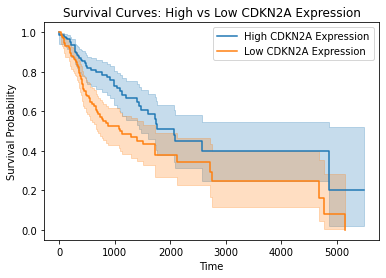

Significant gene for survival analysis CDKN2A. P values: 0.0020200992078091185


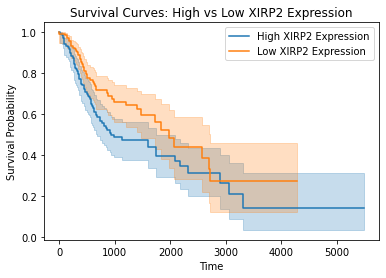

Significant gene for survival analysis XIRP2. P values: 0.020536596511893487


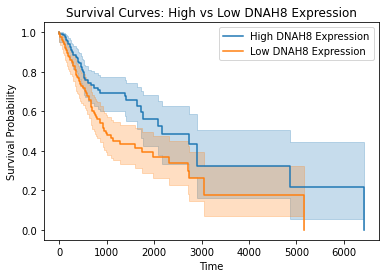

Significant gene for survival analysis DNAH8. P values: 0.004382373678030363


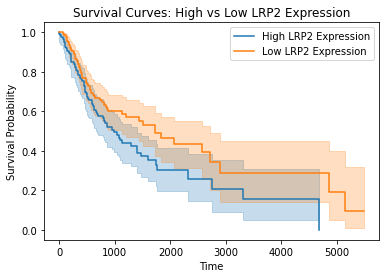

Significant gene for survival analysis LRP2. P values: 0.032305676020434076


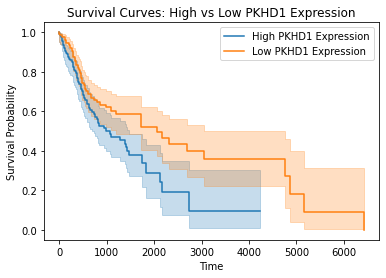

Significant gene for survival analysis PKHD1. P values: 0.010851396456128972


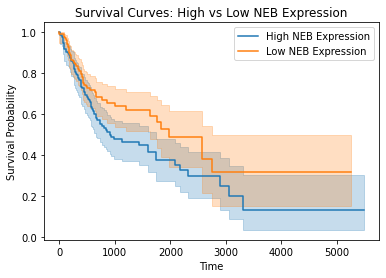

Significant gene for survival analysis NEB. P values: 0.025683915036009173


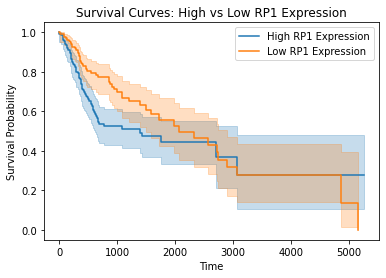

Significant gene for survival analysis RP1. P values: 0.025448747631385403


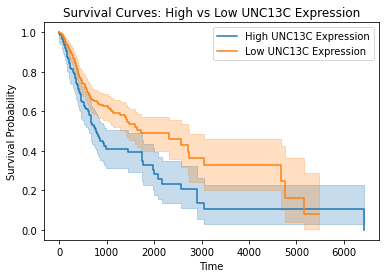

Significant gene for survival analysis UNC13C. P values: 0.0014849029782025007


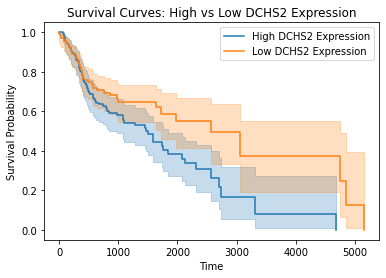

Significant gene for survival analysis DCHS2. P values: 0.021088640921897318


In [75]:

for i in gene_list:
    if i in merged_data.columns:
        quantile_gene(i)
        low_expression = merged_data[merged_data[i + 'binary'] == 0]
        high_expression =  merged_data[merged_data[i +'binary'] == 1]
        # logrank
        results = logrank_test(high_expression['OS.time'], low_expression['OS.time'],
                       high_expression['OS'], low_expression['OS'])
        pvalue = results.p_value
        if pvalue < 0.05:
            kmf = KaplanMeierFitter()

            # Fit the survival curves for high and low expression groups
            kmf.fit(high_expression['OS.time'], event_observed=high_expression['OS'], label='High ' + i + ' Expression')
            kmf.plot()

            kmf.fit(low_expression['OS.time'], event_observed=low_expression['OS'], label='Low ' + i + ' Expression')
            kmf.plot()

            # Add labels and legend
            plt.xlabel('Time')
            plt.ylabel('Survival Probability')
            plt.title('Survival Curves: High vs Low ' + i + ' Expression')
            plt.legend()

            # Show the plot
            plt.show()
            print("Significant gene for survival analysis " + i + ". P values: " + str(pvalue))

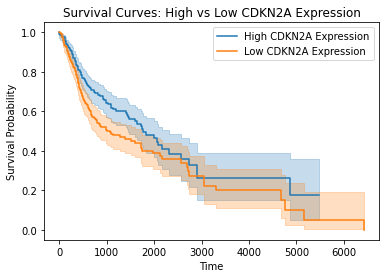

   test_statistic         p  -log2(p)
0        7.230541  0.007167  7.124342


In [78]:
# median
median_value = merged_data['CDKN2A'].median()
# Assuming you have a DataFrame called data with columns 'TP53_expression' and 'Survival_time'

# Split the data into high and low TP53 expression groups
high_expression = merged_data[merged_data['CDKN2A'] >= median_value]
low_expression = merged_data[merged_data['CDKN2A'] < median_value]

# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Fit the survival curves for high and low expression groups
kmf.fit(high_expression['OS.time'], event_observed=high_expression['OS'], label='High CDKN2A Expression')
kmf.plot()

kmf.fit(low_expression['OS.time'], event_observed=low_expression['OS'], label='Low CDKN2A Expression')
kmf.plot()

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Curves: High vs Low CDKN2A Expression')
plt.legend()

# Show the plot
plt.show()
from lifelines.statistics import logrank_test
results = logrank_test(high_expression['OS.time'], low_expression['OS.time'],
                       high_expression['OS'], low_expression['OS'])
print(results.summary)


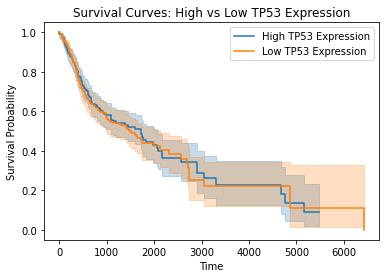

   test_statistic         p  -log2(p)
0        0.101746  0.749745  0.415528


In [80]:
median_value = merged_data['TP53'].median()
# Split the data into high and low TP53 expression groups
high_expression = merged_data[merged_data['TP53'] >= median_value]
low_expression = merged_data[merged_data['TP53'] < median_value]

# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Fit the survival curves for high and low expression groups
kmf.fit(high_expression['OS.time'], event_observed=high_expression['OS'], label='High TP53 Expression')
kmf.plot()

kmf.fit(low_expression['OS.time'], event_observed=low_expression['OS'], label='Low TP53 Expression')
kmf.plot()

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Curves: High vs Low TP53 Expression')
plt.legend()

# Show the plot
plt.show()
from lifelines.statistics import logrank_test
results = logrank_test(high_expression['OS.time'], low_expression['OS.time'],
                       high_expression['OS'], low_expression['OS'])
print(results.summary)

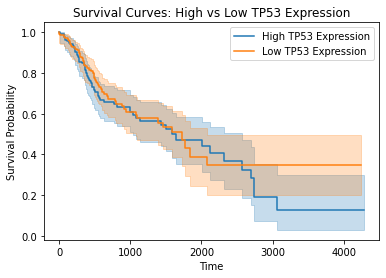

   test_statistic         p  -log2(p)
0        0.350875  0.553618  0.853036


In [81]:
#median_value = merged_data['TP53'].median()
# Split the data into high and low TP53 expression groups
high_expression = merged_data[merged_data['TP53binary'] == 0]
low_expression = merged_data[merged_data['TP53binary'] == 1]

# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Fit the survival curves for high and low expression groups
kmf.fit(high_expression['OS.time'], event_observed=high_expression['OS'], label='High TP53 Expression')
kmf.plot()

kmf.fit(low_expression['OS.time'], event_observed=low_expression['OS'], label='Low TP53 Expression')
kmf.plot()

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Curves: High vs Low TP53 Expression')
plt.legend()

# Show the plot
plt.show()
from lifelines.statistics import logrank_test
results = logrank_test(high_expression['OS.time'], low_expression['OS.time'],
                       high_expression['OS'], low_expression['OS'])
print(results.summary)

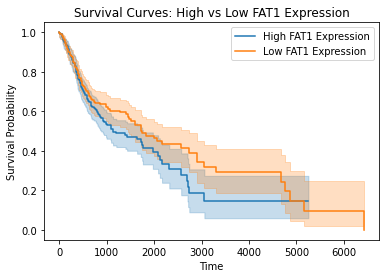

   test_statistic         p  -log2(p)
0        3.110628  0.077783  3.684402


In [ ]:
median_value = merged_data['FAT1'].median()
# Split the data into high and low TP53 expression groups
high_expression = merged_data[merged_data['FAT1'] >= median_value]
low_expression = merged_data[merged_data['FAT1'] < median_value]

# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Fit the survival curves for high and low expression groups
kmf.fit(high_expression['OS.time'], event_observed=high_expression['OS'], label='High FAT1 Expression')
kmf.plot()

kmf.fit(low_expression['OS.time'], event_observed=low_expression['OS'], label='Low FAT1 Expression')
kmf.plot()

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Curves: High vs Low FAT1 Expression')
plt.legend()

# Show the plot
plt.show()
from lifelines.statistics import logrank_test
results = logrank_test(high_expression['OS.time'], low_expression['OS.time'],
                       high_expression['OS'], low_expression['OS'])
print(results.summary)


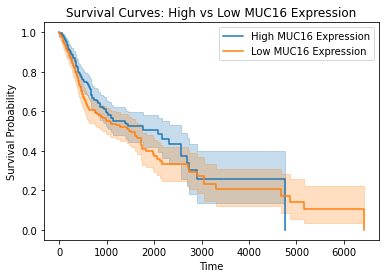

   test_statistic         p  -log2(p)
0        2.353793  0.124979  3.000247


In [59]:
median_value = merged_data['MUC16'].median()
# Split the data into high and low TP53 expression groups
high_expression = merged_data[merged_data['MUC16'] >= median_value]
low_expression = merged_data[merged_data['MUC16'] < median_value]

# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Fit the survival curves for high and low expression groups
kmf.fit(high_expression['OS.time'], event_observed=high_expression['OS'], label='High MUC16 Expression')
kmf.plot()

kmf.fit(low_expression['OS.time'], event_observed=low_expression['OS'], label='Low MUC16 Expression')
kmf.plot()

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Curves: High vs Low MUC16 Expression')
plt.legend()

# Show the plot
plt.show()
from lifelines.statistics import logrank_test
results = logrank_test(high_expression['OS.time'], low_expression['OS.time'],
                       high_expression['OS'], low_expression['OS'])
print(results.summary)

<AxesSubplot:xlabel='CDKN2A', ylabel='ajcc_pathologic_tumor_stage'>

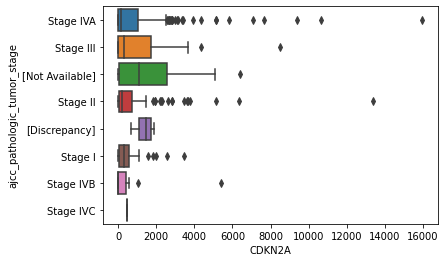

In [11]:


# Explore association between biomarker and potential confounding factors
sns.boxplot(x='CDKN2A', y='ajcc_pathologic_tumor_stage', data=merged_data)
# This creates a boxplot to visualize the distribution of age for different biomarker groups



<AxesSubplot:xlabel='CDKN2A', ylabel='tumor_status'>

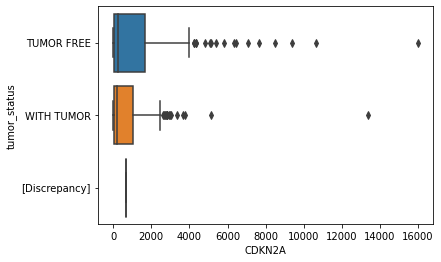

In [12]:
sns.boxplot(x='CDKN2A', y='tumor_status', data=merged_data)
# This creates a boxplot to visualize the distribution of tumor grade for different biomarker groups


<AxesSubplot:xlabel='OS', ylabel='tumor_status'>

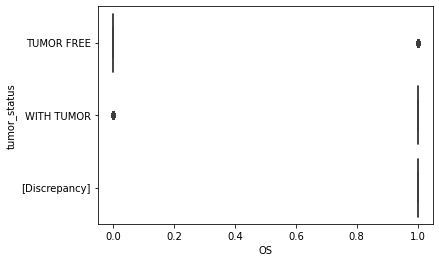

In [13]:
sns.boxplot(x='OS', y='tumor_status', data=merged_data)
# This creates a boxplot to visualize the distribution of tumor grade for different survival outcome groups


/var/folders/x1/0pbqqytx7775hcm5ys9z97y00000gn/T/ipykernel_42927/1026155058.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_data[['CDKN2A', 'ajcc_pathologic_tumor_stage', 'tumor_status', 'OS']].corr()


<AxesSubplot:>

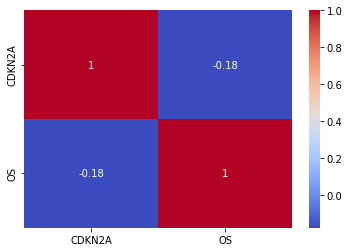

In [14]:
# Compute correlation coefficients between variables
correlation_matrix = merged_data[['CDKN2A', 'ajcc_pathologic_tumor_stage', 'tumor_status', 'OS']].corr()

# Display correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

In [42]:
# perform statistical tests such as t-tests, chi-square tests, or regression models to assess associations

# Example chi-square test for tumor grade and survival outcome
cross_tab = pd.crosstab(merged_data['tumor_status'], merged_data['OS'])
chi2_statistic, p_value, _, _ = stats.chi2_contingency(cross_tab)
print("Chi-square statistic:", chi2_statistic)
print("P-value:", p_value)

# Perform other statistical tests or models as needed based on your data and research objectives

Chi-square statistic: 183.79448847386286
P-value: 1.2289491846615103e-40


In [76]:
def coxfitter(data, duration, event):
    # Define the CoxPHFitter object
    cph = CoxPHFitter()
    # Fit the model to your data
    cph.fit(data, duration_col= duration, event_col=event)
    summary = cph.summary
    if any(summary['p'] < 0.05):  # if any predictor has p-value less than 0.05
        print(f"DataFrame {i} results:")
        print(summary['p'])

In [77]:
for i in gene_list:
    if i in merged_data.columns:
        coxfitter(merged_data[[i ,'OS.time', 'OS']], 'OS.time', 'OS')

DataFrame MUC16 results:
covariate
MUC16    0.0062
Name: p, dtype: float64
DataFrame CDKN2A results:
covariate
CDKN2A    0.000295
Name: p, dtype: float64
DataFrame AHNAK results:
covariate
AHNAK    0.003545
Name: p, dtype: float64
DataFrame PAPPA2 results:
covariate
PAPPA2    0.001476
Name: p, dtype: float64
DataFrame DNAH9 results:
covariate
DNAH9    0.031307
Name: p, dtype: float64
DataFrame LRP2 results:
covariate
LRP2    0.022594
Name: p, dtype: float64
DataFrame FMN2 results:
covariate
FMN2    0.044757
Name: p, dtype: float64
DataFrame RP1 results:
covariate
RP1    0.008376
Name: p, dtype: float64
DataFrame CLCA4 results:
covariate
CLCA4    0.037141
Name: p, dtype: float64


In [86]:
# preprocessing for other convariates
gene = merged_data.copy()
#drop race which is not available or unknown or not evaluated
gene = gene[gene['ajcc_pathologic_tumor_stage'] != '[Not Available]']
gene = gene[gene['ajcc_pathologic_tumor_stage'] != '[Discrepancy]']
gene['gender'] = gene['gender'].map({'MALE': 1, 'FEMALE': 0})
gene['tumor_status'] = gene['tumor_status'].map({'TUMOR FREE': 1, 'WITH TUMOR': 0})
gene['ajcc_pathologic_tumor_stage'] = gene['ajcc_pathologic_tumor_stage'].map({'Stage I': 1, 
                                                                               'Stage II': 2,
                                                                              'Stage III': 3,
                                                                              'Stage IVA': 4.3,
                                                                              'Stage IVB': 4.6,
                                                                              'Stage IVC': 5})



In [ ]:
def coxfitter(data, duration, event):
    # Define the CoxPHFitter object
    cph = CoxPHFitter()
    # Fit the model to your data
    cph.fit(data, duration_col= duration, event_col=event)
    summary = cph.summary
    if any(summary['p'] < 0.05):  # if any predictor has p-value less than 0.05
        print(f"DataFrame {i} results:")
        print(summary['p'])

In [ ]:
cph = CoxPHFitter()
# Fit the model to your data
cph.fit(data, duration_col= duration, event_col=event)
summary = cph.summary

# DSS analysis

In [41]:
merged_data = merged_data.dropna(subset = ['DSS.time', 'DSS'])
coxfitter(merged_data[['TP53','DSS.time', 'DSS']], 'DSS.time', 'DSS')

<lifelines.CoxPHFitter: fitted with 516 total observations, 366 right-censored observations>
             duration col = 'DSS.time'
                event col = 'DSS'
      baseline estimation = breslow
   number of observations = 516
number of events observed = 150
   partial log-likelihood = -844.95
         time fit was run = 2023-05-29 19:18:02 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
TP53       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

            cmp to     z    p   -log2(p)
covariate                               
TP53          0.00 -1.09 0.28       1.85
---
Concordance = 0.53
Partial AIC = 1691.89
log-likelihood ratio test = 1.22 on 1 df
-log2(p) of ll-ratio test = 1.89

None
